# Data visualization

## STEP 0: Environment setup
Import libraries, load config, and initialize logging.

In [ ]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging

# Import centralized configuration + logger utility
sys.path.append(os.path.abspath('../src'))
import config
from utils import setup_logger

logger = setup_logger(
    name="data-visualization",
    log_dir=getattr(config, 'LOG_DIR', os.path.join(os.getcwd(), 'log')),
    filename="data_visualization.log",
    level=logging.INFO,
    mode='w',
)

## STEP 1: Load cleaned dataset
Load `vehicle_positions_cleaned.csv` and parse timestamps for time-based plots.

In [ ]:
cleaned_path = getattr(
    config,
    'CLEANED_CSV_PATH',
    os.path.join(getattr(config, 'DATA_DIR', os.path.join(os.getcwd(), 'data')), 'vehicle_positions_cleaned.csv'),
)

logger.info(f"Loading cleaned data from: {cleaned_path}")

if os.path.exists(cleaned_path):
    df = pd.read_csv(cleaned_path)
    logger.info("Success: Cleaned data loaded.")
    if 'timestamp' in df.columns:
        df['dt'] = pd.to_datetime(df['timestamp'])
else:
    raise FileNotFoundError(f"Cleaned dataset not found at {cleaned_path}")

Loading cleaned data from: /home/fustli/Documents/Uni/DeepL/End-of-trip_delay_prediction/data/vehicle_positions_cleaned.csv
Success: Cleaned data loaded.


## STEP 2: EDA plots
Generate core spatial/temporal/statistical plots and save them under `plots/`.

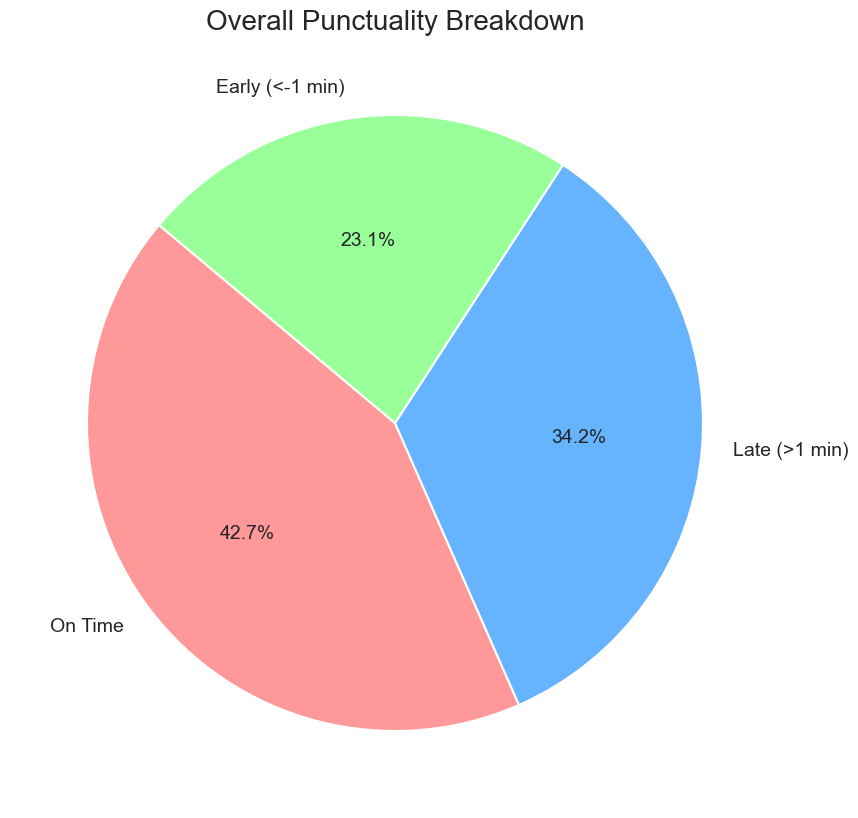

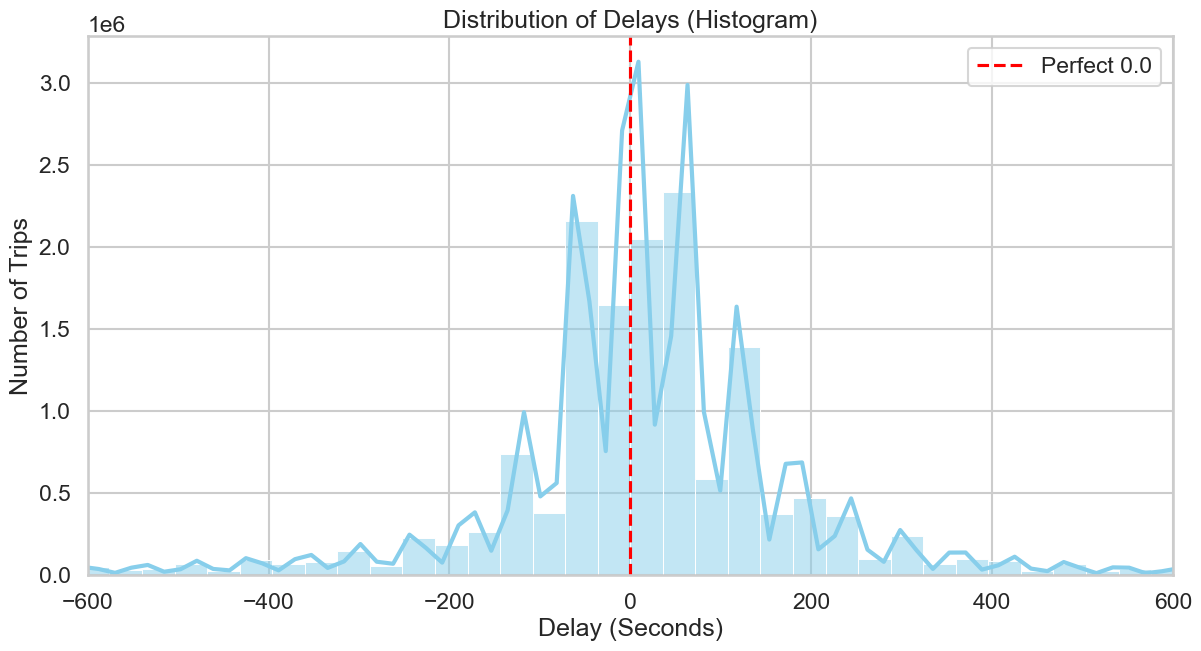

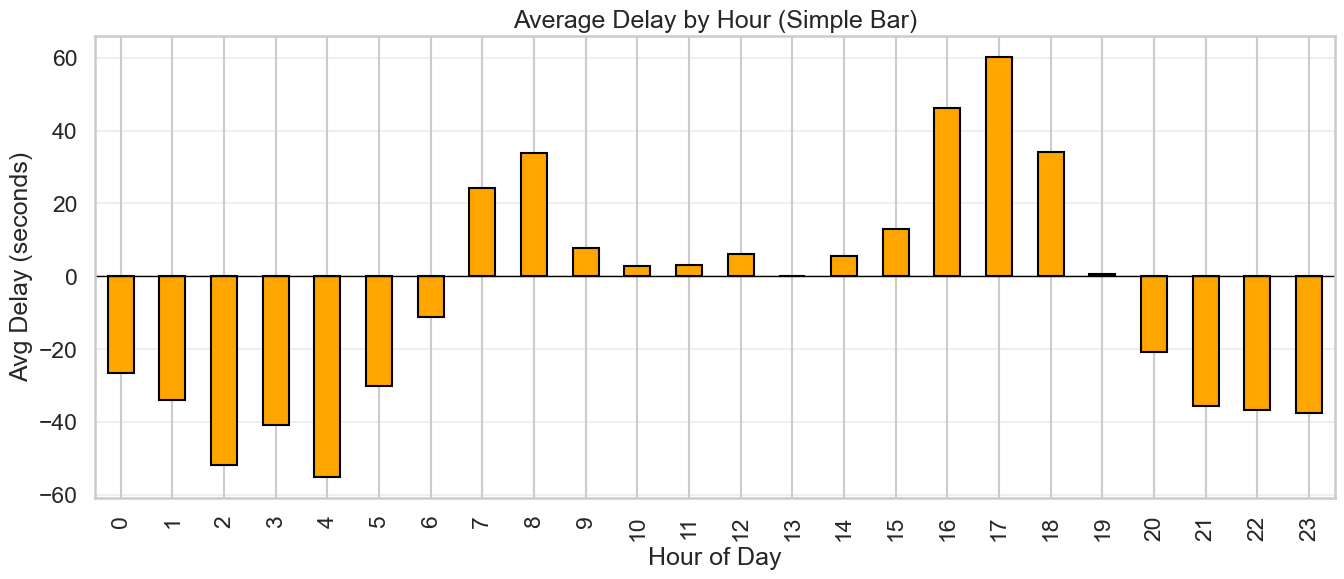

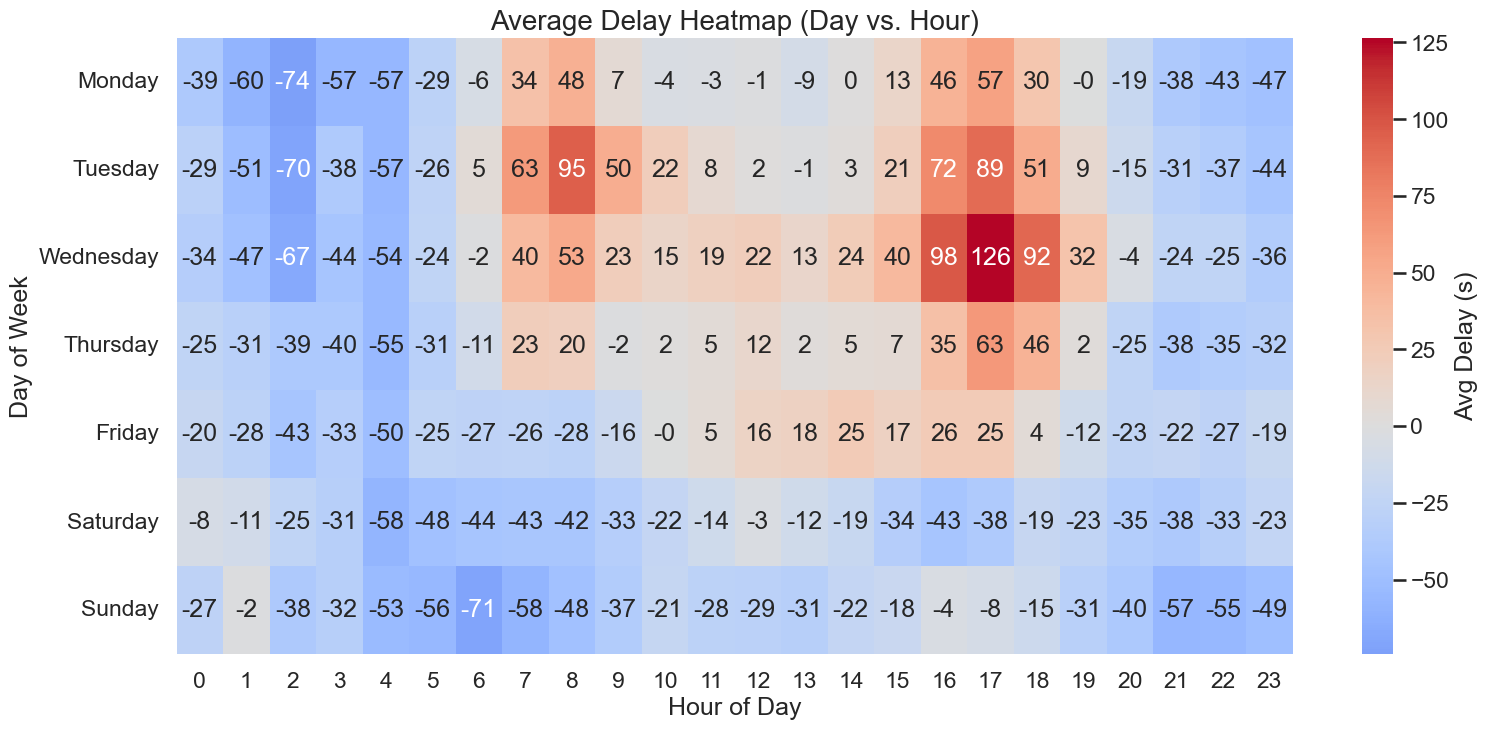

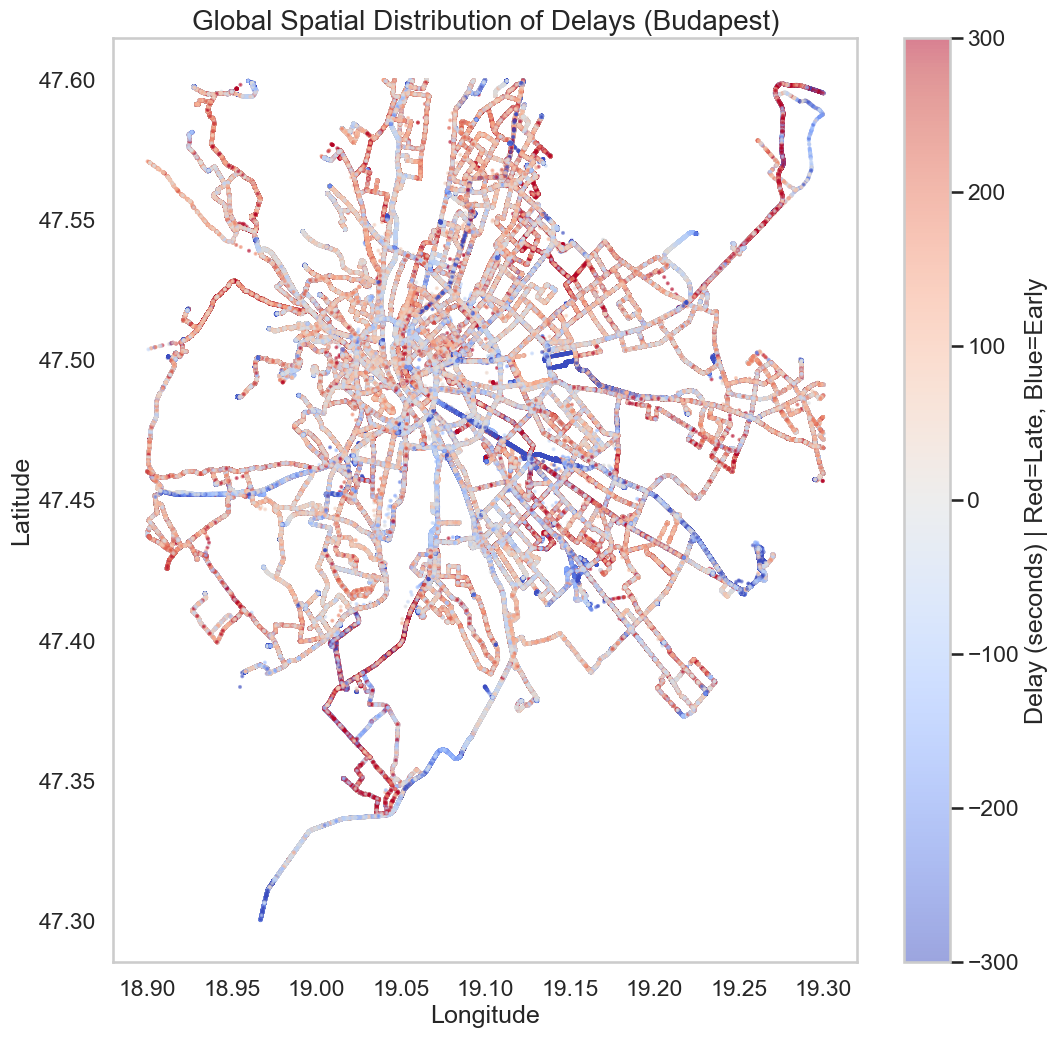

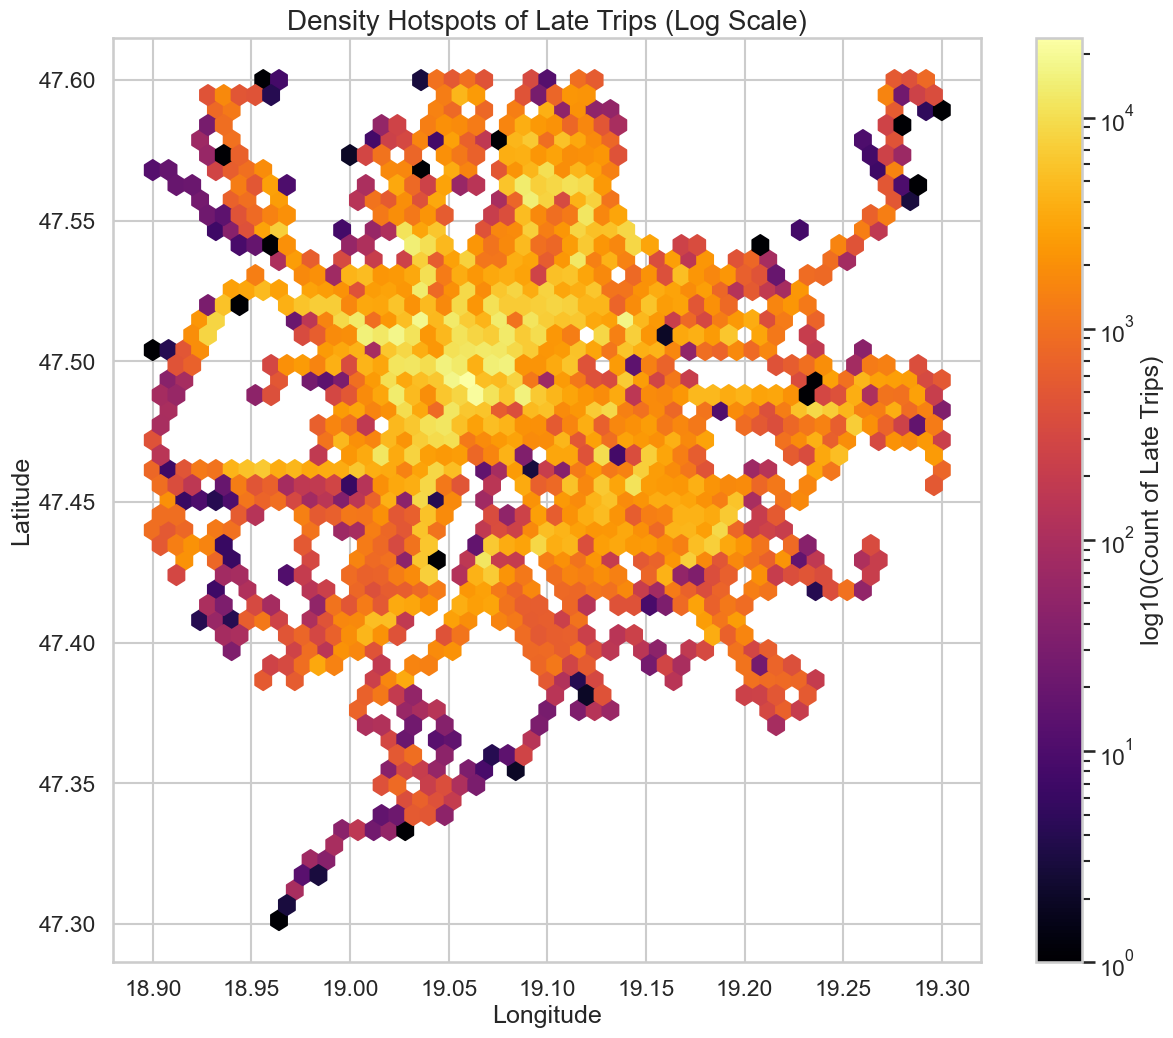

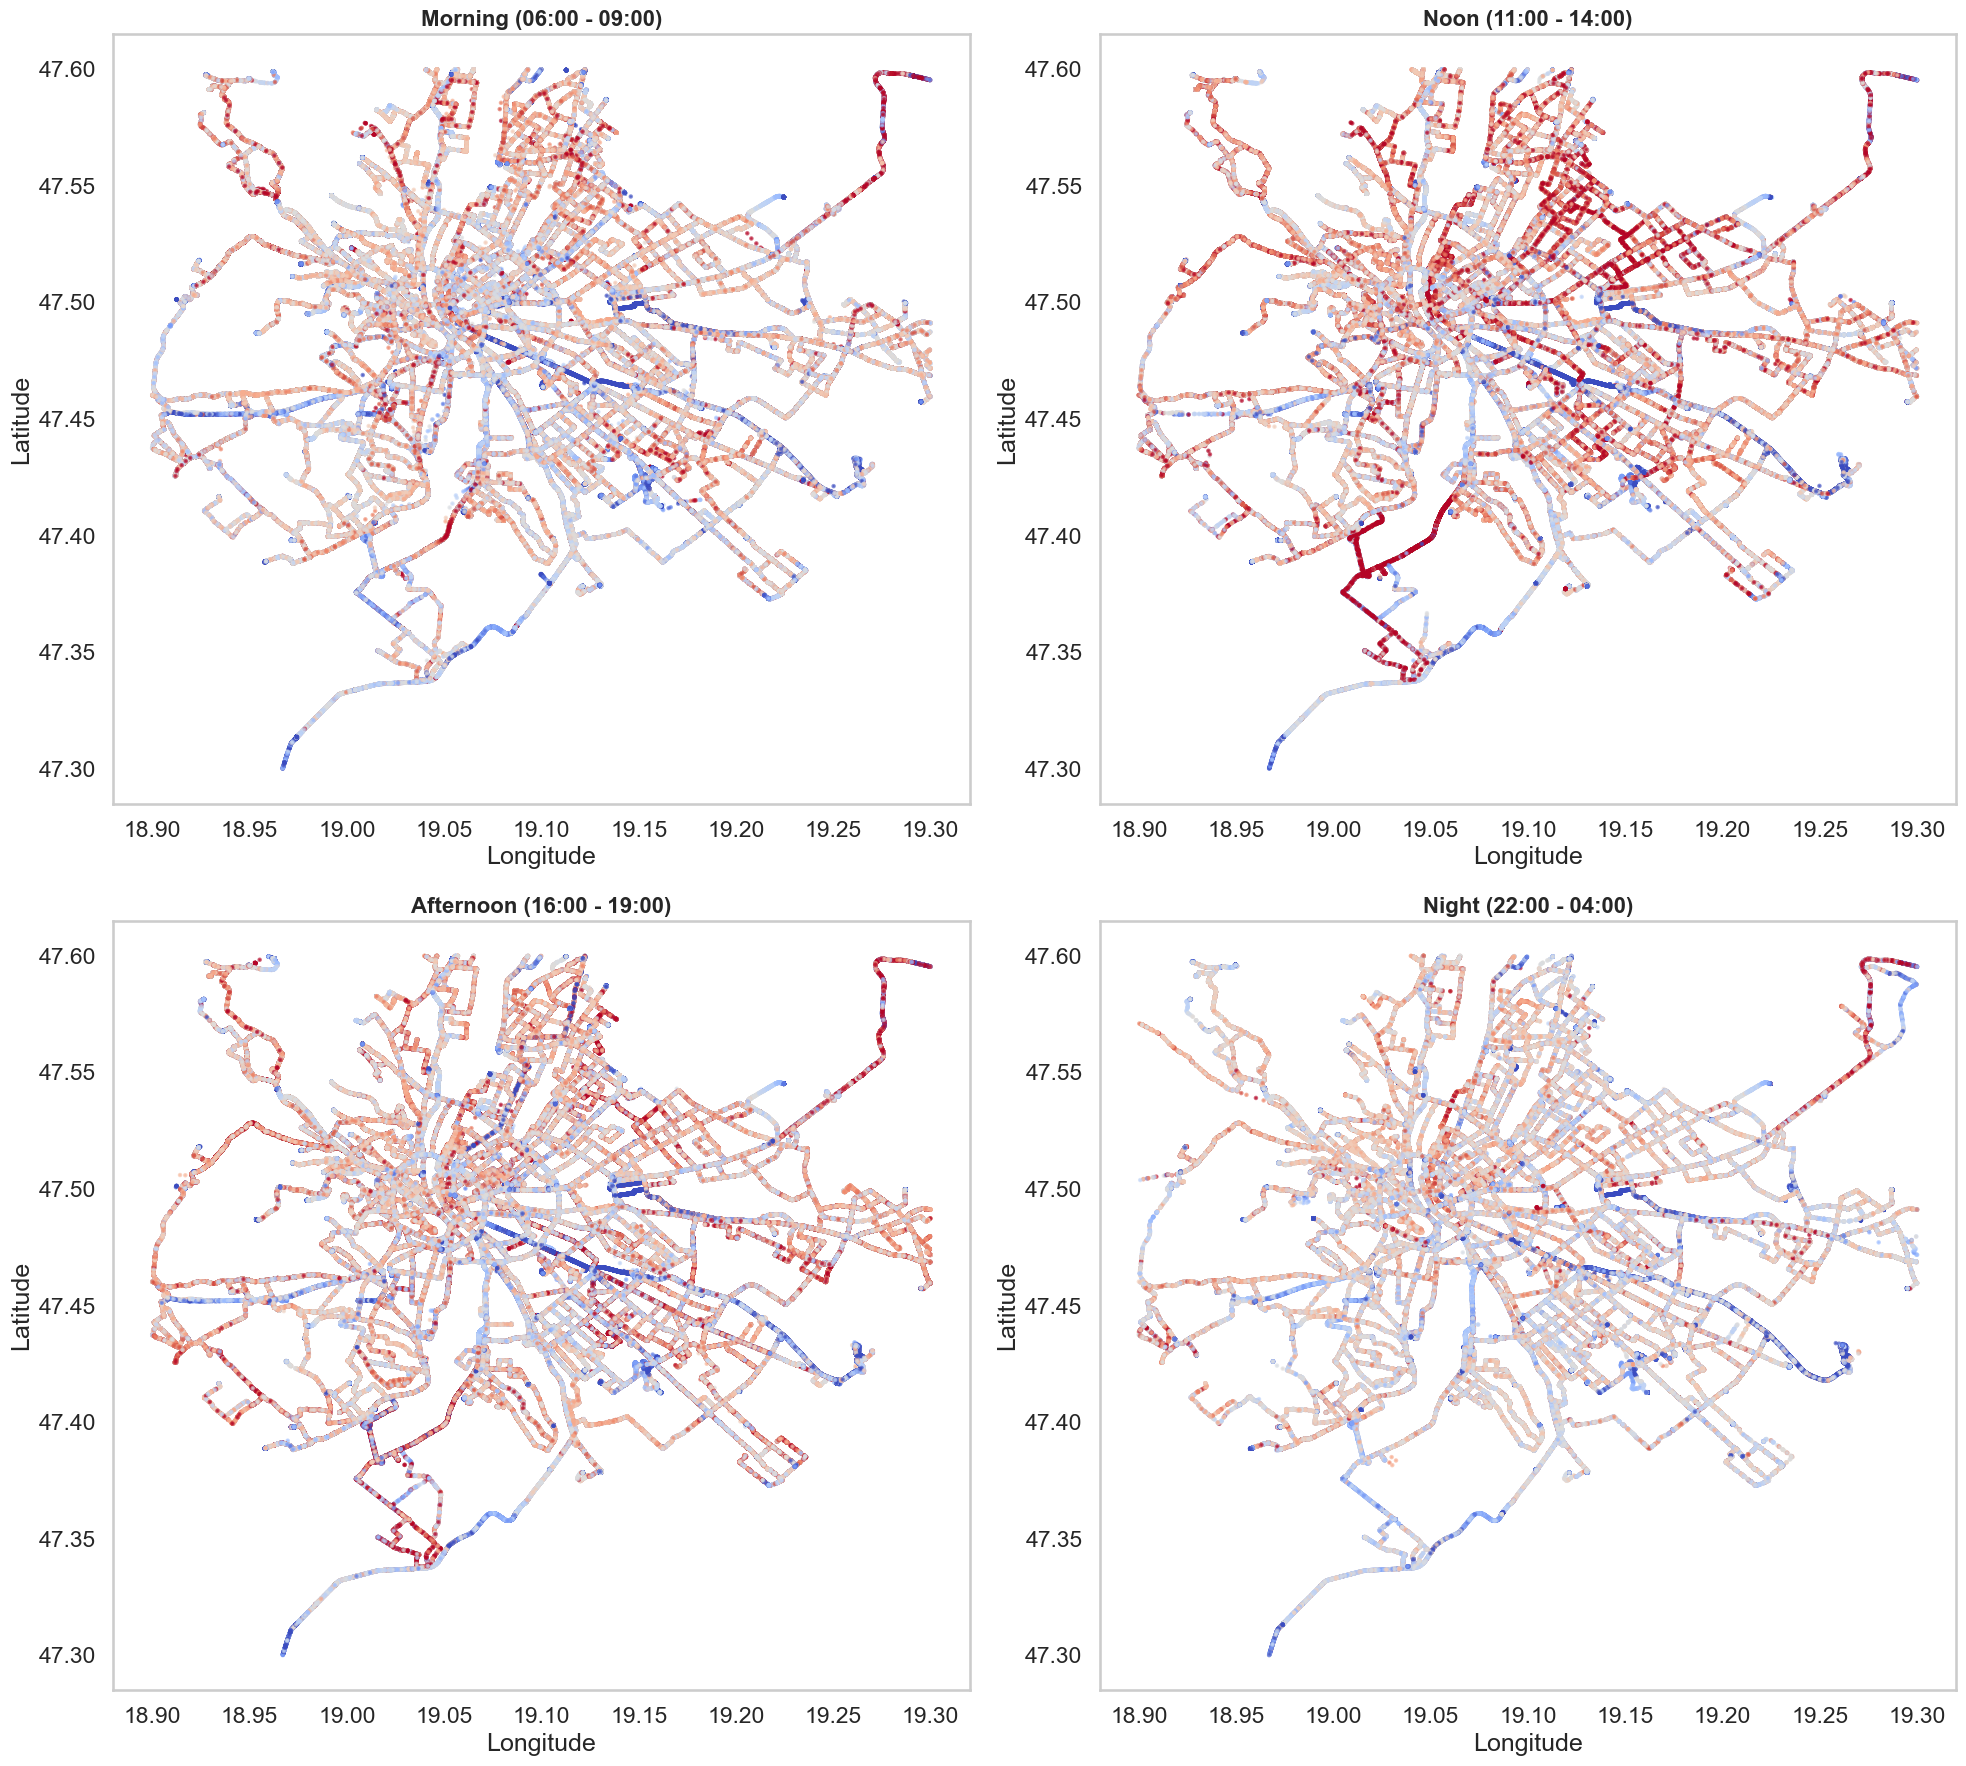

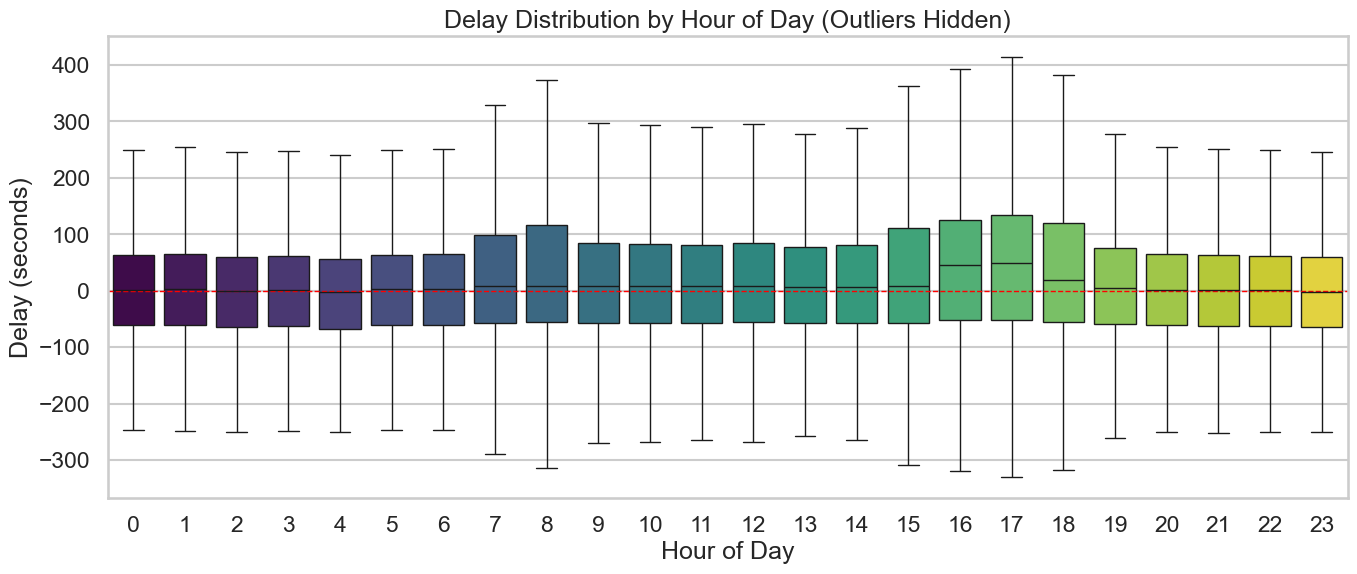

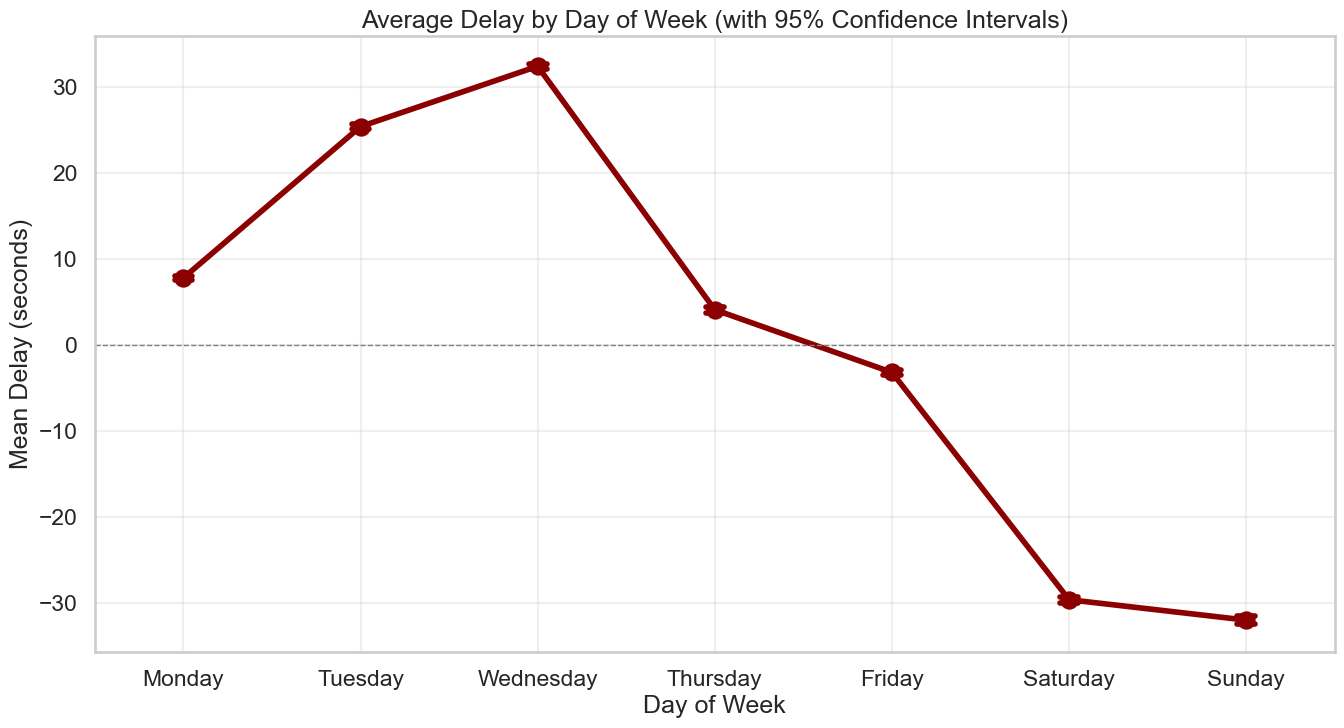

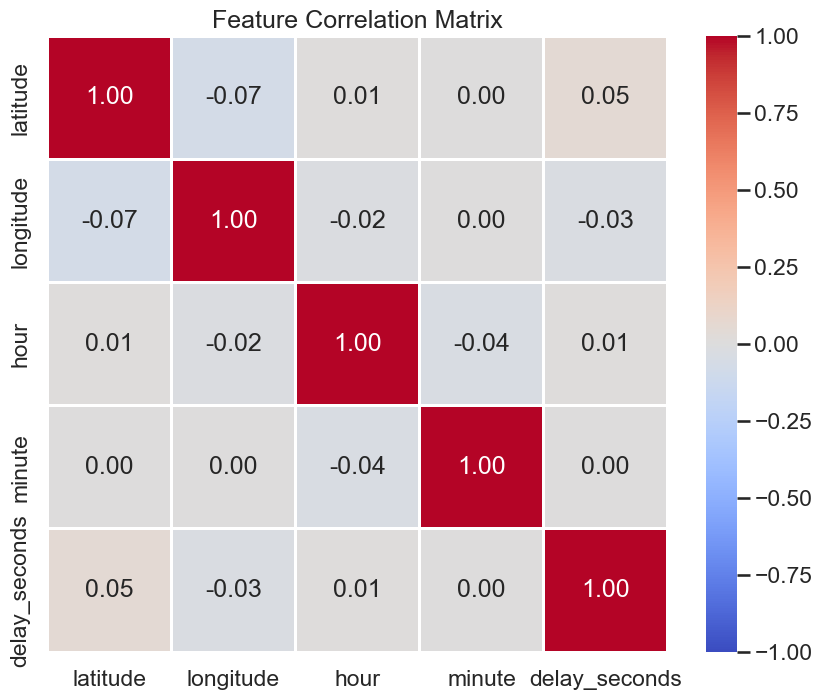

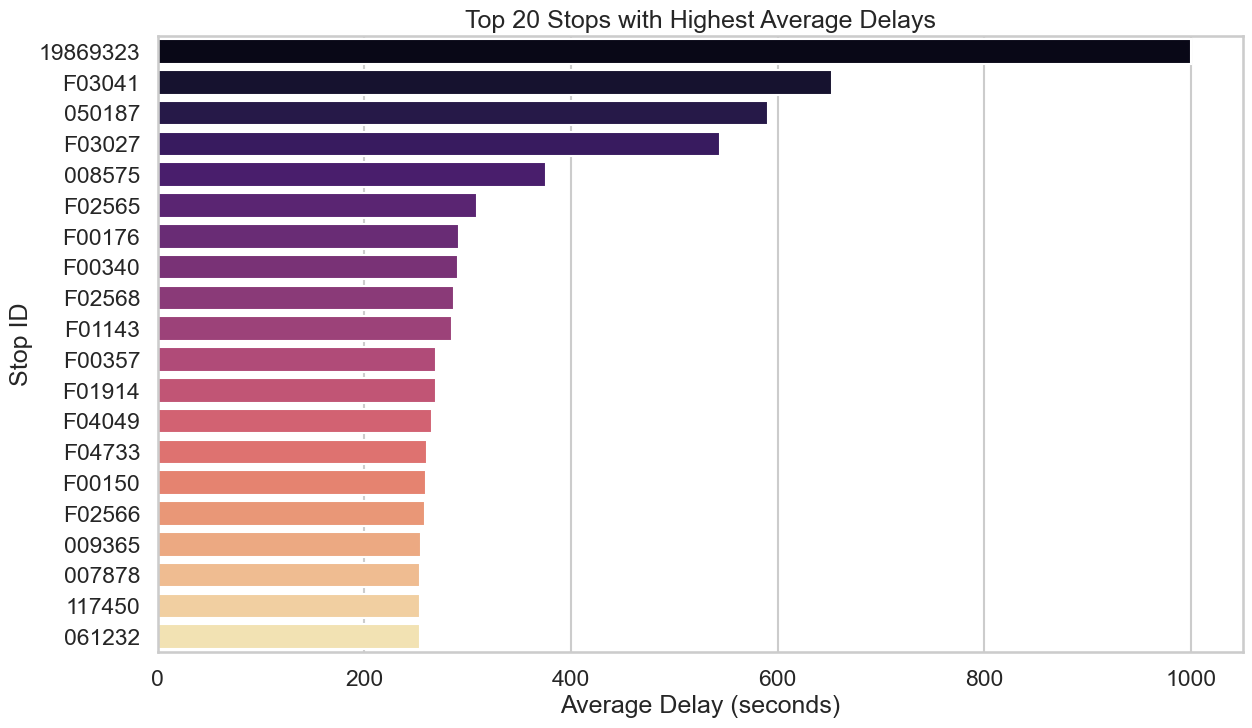

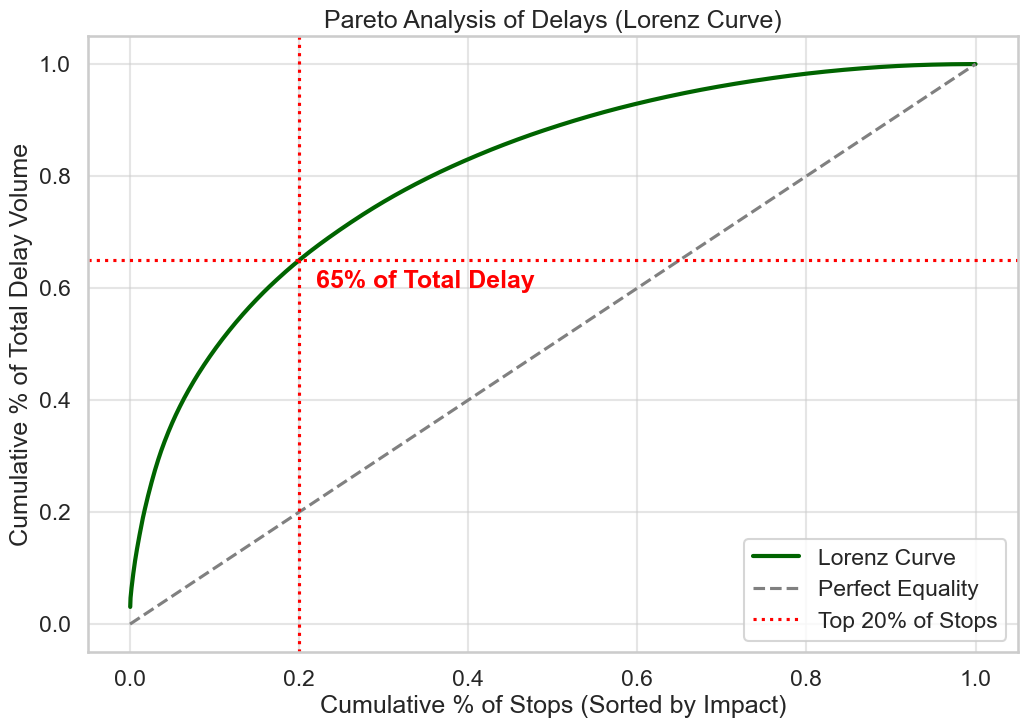

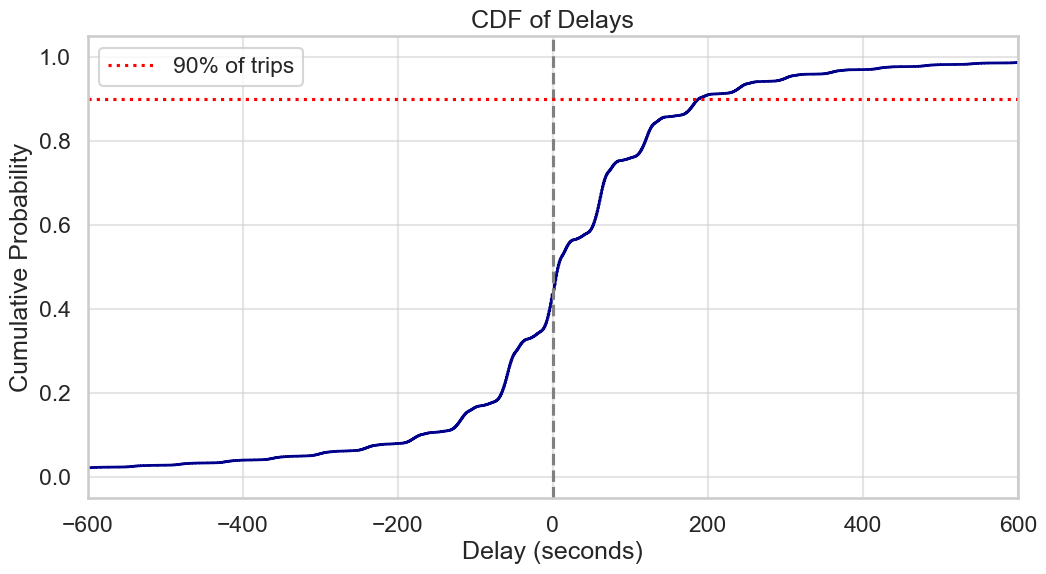

ADVANCED INSIGHTS
Total Data Points: 15,065,416
Percentage of Late Trips (> 1 min):  34.2%
Percentage of Early Trips (< -1 min): 23.1%
Percentage On Time (+/- 1 min):       42.7%
------------------------------------------------------------
Most Delayed Stop (Avg):
               mean  count
last_stop_id              
19869323     999.74  17860
Pareto Insight: Top 20% of stops account for 65.0% of total delay volume.


In [ ]:
# =============================================================================
# SETUP & STYLE
# =============================================================================
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 10)
pd.options.display.float_format = '{:.2f}'.format

plots_dir = os.path.abspath(getattr(config, 'PLOTS_DIR', os.path.join(os.getcwd(), 'plots')))
os.makedirs(plots_dir, exist_ok=True)
logger.info(f"Plots will be saved to: {plots_dir}")

def _save_fig(filename: str) -> str:
    path = os.path.join(plots_dir, filename)
    plt.savefig(path, dpi=150, bbox_inches='tight')
    logger.info(f"Saved figure: {path}")
    return path

# Ensure datetime features exist
if 'dt' in df.columns:
    df['hour'] = df['dt'].dt.hour
    df['minute'] = df['dt'].dt.minute
    df['day_of_week'] = df['dt'].dt.day_name()

# Define sort order for days (used in multiple charts)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Filter valid coordinates globally for geospatial plots
lat_min = float(getattr(config, 'LAT_MIN', 47.30))
lat_max = float(getattr(config, 'LAT_MAX', 47.65))
lon_min = float(getattr(config, 'LON_MIN', 18.90))
lon_max = float(getattr(config, 'LON_MAX', 19.35))
geo_df = df[(df['latitude'] > lat_min) & (df['latitude'] < lat_max) & (df['longitude'] > lon_min) & (df['longitude'] < lon_max)]

# =============================================================================
# PART A: HIGH-LEVEL OVERVIEW (SIMPLE CHARTS)
# =============================================================================

# 1. OVERALL PUNCTUALITY (Pie Chart)
# -----------------------------------------------------------------------------
# "How often are we actually late?"
status_counts = df['delay_seconds'].apply(lambda x:
    'Late (>1 min)' if x > 60 else
    'Early (<-1 min)' if x < -60 else
    'On Time'
).value_counts()

plt.figure(figsize=(10, 10))
plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    colors=['#ff9999', '#66b3ff', '#99ff99'],
    startangle=140,
    textprops={'fontsize': 14}
 )
plt.title('Overall Punctuality Breakdown', fontsize=20)
_save_fig('eda_overall_punctuality_pie.png')
plt.show()

# 2. DISTRIBUTION SHAPE (Histogram)
# -----------------------------------------------------------------------------
# "Is the delay random or skewed?"
plt.figure(figsize=(14, 7))
sns.histplot(
    df['delay_seconds'],
    bins=100,
    kde=True,
    color='skyblue',
    line_kws={'linewidth': 3, 'color': 'darkblue'}
 )
plt.xlim(-600, 600)
plt.axvline(0, color='red', linestyle='--', label='Perfect 0.0')
plt.title('Distribution of Delays (Histogram)', fontsize=18)
plt.xlabel('Delay (Seconds)')
plt.ylabel('Number of Trips')
plt.legend()
_save_fig('eda_delay_histogram.png')
plt.show()

# 3. HOURLY TREND (Simple Bar Chart)
# -----------------------------------------------------------------------------
# "When is the peak delay?"
hourly_avg = df.groupby('hour')['delay_seconds'].mean()

plt.figure(figsize=(16, 6))
hourly_avg.plot(kind='bar', color='orange', edgecolor='black')
plt.axhline(0, color='black', linewidth=1)
plt.title('Average Delay by Hour (Simple Bar)', fontsize=18)
plt.xlabel('Hour of Day')
plt.ylabel('Avg Delay (seconds)')
plt.grid(axis='y', alpha=0.3)
_save_fig('eda_avg_delay_by_hour_bar.png')
plt.show()

# 4. WEEKLY PATTERN (Heatmap)
# -----------------------------------------------------------------------------
# "The Traffic Grid: Day vs Hour"
if 'dt' in df.columns:
    pivot_table = df.pivot_table(
        index='day_of_week',
        columns='hour',
        values='delay_seconds',
        aggfunc='mean'
    )
    pivot_table = pivot_table.reindex(days_order)

    plt.figure(figsize=(18, 8))
    sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".0f",
        cbar_kws={'label': 'Avg Delay (s)'}
    )
    plt.title('Average Delay Heatmap (Day vs. Hour)', fontsize=20)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    _save_fig('eda_delay_heatmap_day_vs_hour.png')
    plt.show()

# =============================================================================
# PART B: GEOSPATIAL ANALYSIS
# =============================================================================

# 5. GLOBAL DELAY MAP (Scatter)
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 12))
scatter = plt.scatter(
    geo_df['longitude'],
    geo_df['latitude'],
    c=geo_df['delay_seconds'],
    cmap='coolwarm',
    s=2,
    alpha=0.5,
    vmin=-300,
    vmax=300
 )
plt.colorbar(scatter, label='Delay (seconds) | Red=Late, Blue=Early')
plt.title('Global Spatial Distribution of Delays (Budapest)', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
_save_fig('eda_global_spatial_delay_scatter.png')
plt.show()

# 6. DENSITY HOTSPOTS (Hexbin Map)
# -----------------------------------------------------------------------------
# Focuses on WHERE the most late trips occur
late_trips = geo_df[geo_df['delay_seconds'] > 120]

if not late_trips.empty:
    plt.figure(figsize=(14, 12))
    hb = plt.hexbin(
        late_trips['longitude'],
        late_trips['latitude'],
        gridsize=50,
        cmap='inferno',
        mincnt=1,
        bins='log'
    )
    plt.colorbar(hb, label='log10(Count of Late Trips)')
    plt.title('Density Hotspots of Late Trips (Log Scale)', fontsize=20)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    _save_fig('eda_late_trip_density_hexbin.png')
    plt.show()
else:
    logger.warning("Not enough late trips for Hexbin map.")

# 7. TEMPORAL SPLIT MAP (4-Panels)
# -----------------------------------------------------------------------------
mask_morning = (geo_df['hour'] >= 6) & (geo_df['hour'] <= 9)
mask_noon = (geo_df['hour'] >= 11) & (geo_df['hour'] <= 14)
mask_afternoon = (geo_df['hour'] >= 16) & (geo_df['hour'] <= 19)
mask_night = (geo_df['hour'] >= 22) | (geo_df['hour'] <= 4)

slices = [
    ('Morning (06:00 - 09:00)', mask_morning),
    ('Noon (11:00 - 14:00)', mask_noon),
    ('Afternoon (16:00 - 19:00)', mask_afternoon),
    ('Night (22:00 - 04:00)', mask_night),
]

fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

for ax, (title, mask) in zip(axes, slices):
    subset = geo_df[mask]
    if not subset.empty:
        sc = ax.scatter(
            subset['longitude'],
            subset['latitude'],
            c=subset['delay_seconds'],
            cmap='coolwarm',
            s=3,
            alpha=0.6,
            vmin=-300,
            vmax=300,
        )
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(False)
    else:
        ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center')
plt.tight_layout()
fig.savefig(os.path.join(plots_dir, 'eda_temporal_split_spatial_maps.png'), dpi=150, bbox_inches='tight')
logger.info(f"Saved figure: {os.path.join(plots_dir, 'eda_temporal_split_spatial_maps.png')}")
plt.show()

# =============================================================================
# PART C: ADVANCED STATISTICAL & STOP ANALYSIS
# =============================================================================

# 8. DETAILED HOURLY VARIANCE (Boxplots)
# -----------------------------------------------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(
    x='hour',
    y='delay_seconds',
    hue='hour',
    data=df,
    showfliers=False,
    palette="viridis",
    legend=False,
 )
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Delay Distribution by Hour of Day (Outliers Hidden)', fontsize=18)
plt.xlabel('Hour of Day')
plt.ylabel('Delay (seconds)')
_save_fig('eda_delay_boxplot_by_hour.png')
plt.show()

# 9. DAY OF WEEK ANALYSIS (Confidence Intervals)
# -----------------------------------------------------------------------------
if 'dt' in df.columns:
    plt.figure(figsize=(16, 8))
    sns.pointplot(
        x='day_of_week',
        y='delay_seconds',
        data=df,
        order=days_order,
        capsize=0.1,
        color='darkred',
        errorbar=('ci', 95),
    )
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title('Average Delay by Day of Week (with 95% Confidence Intervals)', fontsize=18)
    plt.xlabel('Day of Week')
    plt.ylabel('Mean Delay (seconds)')
    plt.grid(True, alpha=0.3)
    _save_fig('eda_avg_delay_by_weekday_ci.png')
    plt.show()

# 10. CORRELATION MATRIX
# -----------------------------------------------------------------------------
corr_cols = ['latitude', 'longitude', 'hour', 'minute', 'delay_seconds']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=1,
 )
plt.title('Feature Correlation Matrix', fontsize=18)
_save_fig('eda_feature_correlation_matrix.png')
plt.show()

# 11. TOP 20 WORST STOPS
# -----------------------------------------------------------------------------
stop_id_col = 'last_stop_id' if 'last_stop_id' in df.columns else 'stop_id'
stop_delays = df.groupby(stop_id_col)['delay_seconds'].agg(['mean', 'count'])
stop_delays = stop_delays[stop_delays['count'] > 50].sort_values('mean', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=stop_delays.head(20)['mean'],
    y=stop_delays.head(20).index,
    hue=stop_delays.head(20).index,
    palette='magma',
    legend=False,
 )
plt.title('Top 20 Stops with Highest Average Delays', fontsize=18)
plt.xlabel('Average Delay (seconds)')
plt.ylabel('Stop ID')
_save_fig('eda_top20_stops_by_avg_delay.png')
plt.show()

# 12. PARETO ANALYSIS (Lorenz Curve)
# -----------------------------------------------------------------------------
stop_impact = df.assign(abs_delay=df['delay_seconds'].abs()).groupby(stop_id_col)['abs_delay'].sum()
stop_impact = stop_impact.sort_values(ascending=False)
cum_impact = stop_impact.cumsum() / stop_impact.sum()
cum_stops = np.arange(1, len(stop_impact) + 1) / len(stop_impact)

plt.figure(figsize=(12, 8))
plt.plot(cum_stops, cum_impact, color='darkgreen', linewidth=3, label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality')

plt.axvline(0.2, color='red', linestyle=':', label='Top 20% of Stops')
impact_at_20 = cum_impact.iloc[int(len(cum_impact) * 0.2)]
plt.axhline(impact_at_20, color='red', linestyle=':')
plt.text(0.22, impact_at_20 - 0.05, f'{impact_at_20:.0%} of Total Delay', color='red', fontweight='bold')

plt.title('Pareto Analysis of Delays (Lorenz Curve)', fontsize=18)
plt.xlabel('Cumulative % of Stops (Sorted by Impact)')
plt.ylabel('Cumulative % of Total Delay Volume')
plt.legend()
plt.grid(True, alpha=0.5)
_save_fig('eda_pareto_lorenz_curve.png')
plt.show()

# 13. CDF & TEXT SUMMARY
# -----------------------------------------------------------------------------
sorted_data = np.sort(df['delay_seconds'])
yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)

plt.figure(figsize=(12, 6))
plt.plot(sorted_data, yvals, color='darkblue', linewidth=2)
plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0.9, color='red', linestyle=':', label='90% of trips')
plt.title('CDF of Delays', fontsize=18)
plt.xlabel('Delay (seconds)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xlim(-600, 600)
_save_fig('eda_delay_cdf.png')
plt.show()

logger.info("=" * 60)
logger.info("ADVANCED INSIGHTS")
logger.info("=" * 60)
logger.info(f"Total Data Points: {len(df):,}")
logger.info(f"Percentage of Late Trips (> 1 min):   {100 * (df['delay_seconds'] > 60).mean():.1f}%")
logger.info(f"Percentage of Early Trips (< -1 min): {100 * (df['delay_seconds'] < -60).mean():.1f}%")
logger.info(f"Percentage On Time (+/- 1 min):        {100 * ((df['delay_seconds'] >= -60) & (df['delay_seconds'] <= 60)).mean():.1f}%")
logger.info("-" * 60)
logger.info("Most Delayed Stop (Avg):")
logger.info(stop_delays.head(1).to_string())
logger.info(f"Pareto Insight: Top 20% of stops account for {impact_at_20:.1%} of total delay volume.")
logger.info("=" * 60)